In [157]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

path_opr = r'C:\Users\Alexei\Desktop\Works\analytics\opr\data'
path_pdn = r'C:\Users\Alexei\Desktop\podnevka'

In [115]:
f = glob(path_opr + '\\' + '*.csv')
opr = [i for i in f if 'opr_' in i]

print('Найдено файлов для обработки: {}'.format(len(opr)))

Найдено файлов для обработки: 7


In [123]:
columns = ['Вид', 'Клиент', 'Дог.', 'Сумма', 'Дата выполнения', 'Тип продукта']

df = pd.read_csv(opr[0], sep = ';', encoding = 'cp1251', decimal = b',', dtype = {'Сумма': 'float'})
df = df.reindex(columns = columns)

for i in range(1, len(opr)):
    tmp = pd.read_csv(opr[i], sep = ';', encoding = 'cp1251', decimal = b',', dtype = {'Сумма': 'float'})
    tmp = tmp.reindex(columns = columns)
    df  = df.append(tmp, ignore_index = True)
    
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

df = df[df['Тип продукта'] != 'auto-lombard']
df.drop('Тип продукта', axis = 1, inplace = True)

df['on_off'] = list(map(lambda x: '/ON/' in x, df['Дог.']))
df = df[df['on_off'] == True]
df.drop('on_off', axis = 1, inplace = True)

df['Дата выполнения'] = list(map(lambda x: pd.to_datetime(x.split(' ')[0], dayfirst = True), df['Дата выполнения']))

print('Кол-во строк в консолидированном отчете по операциям: {}'.format(df.shape[0]))

Кол-во строк в консолидированном отчете по операциям: 235493


In [179]:
df_v = df[['Дог.', 'Дата выполнения']][df['Вид'] == 'Выдача займа']
df_v = df_v[df_v['Дата выполнения'] < '2019-07-01']
df_p = df[df['Вид'] == 'Разноска']

In [180]:
df_pv = pd.merge(left = df_p, right = df_v, how = 'left', on = 'Дог.', validate = 'many_to_one')
df_pv = df_pv[pd.isnull(df_pv['Дата выполнения_y']) == False]

In [181]:
df_pv['Кол-во дней'] = df_pv['Дата выполнения_x'] - df_pv['Дата выполнения_y']
df_pv['Кол-во дней'] = list(map(lambda x: x.days, df_pv['Кол-во дней']))

In [182]:
df_pv = df_pv[(df_pv['Кол-во дней'] != 0) & (df_pv['Кол-во дней'] < 51)]

In [183]:
days = sorted(set(df_pv['Кол-во дней']))
summa = sum(df_pv['Сумма'])
frac = []
for i in days:
    sum(df_pv[df_pv['Кол-во дней'] == i]['Сумма']) / summa
    frac.append(round(100 * sum(df_pv[df_pv['Кол-во дней'] == i]['Сумма']) / summa, 2))

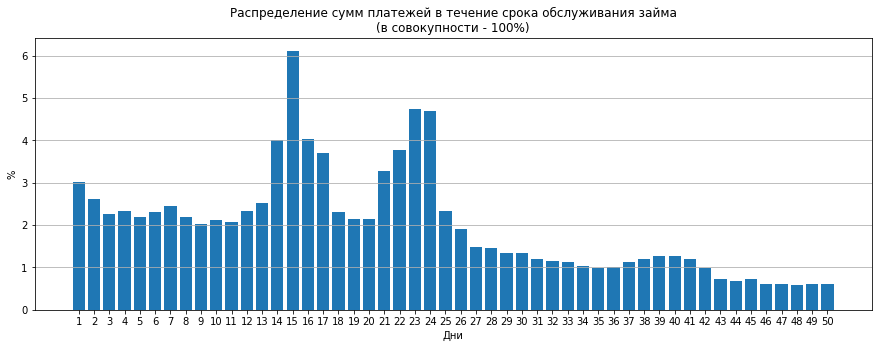

In [191]:
plt.figure(figsize = (15, 5))
plt.bar(days, frac)
plt.grid(axis = 'y')
plt.xticks(days)
plt.ylabel('%')
plt.xlabel('Дни')
plt.title('Распределение сумм платежей в течение срока обслуживания займа\n(в совокупности - 100%)')
plt.show()